# Real time: FRB 220418aaai (SN10.4)

In [1]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn_vec, sgram_fn_vec, sgram_fn, gauss, gauss_norm, model_free_4,model_free, power_law
from burstfit.utils.plotter import plot_fit_results, plot_2d_fit 
from burstfit.io import BurstIO
import logging
import numpy as np
import math
import matplotlib.pyplot as plt
# use Liam's function to read in filterbank files 
import sys
sys.path.insert(1, '/home/ubuntu/gechen/software')
import filplot_funcs_gc as ff

#from burstfit.utils.functions import gauss_norm2, pulse_fn_vec, sgram_fn_vec 
%matplotlib inline 


# input variables 
candidate = '220418aaai'
datestring = '2022_4_18_4_58_12'
beam = 66
corr = 'corr02'
dm_heimdall = 624.1
width_heimdall = 4 
snr_heimdall = 10.4
mask_chans=[] 

fil_file ='/data/dsa110/T1/'+corr + '/' + datestring + '/fil_'+candidate+'/'+candidate+'_'+str(beam)+'.fil'
save_name = candidate + '_beam_'+str(beam)
save_dir = '/home/ubuntu/gechen/burstfit_tests_outputs/' 


#data = ff.proc_cand_fil(fil_file, dm, width, nfreq_plot=64, ndm=64)[0]
#data_t = data.mean(0)

logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=logging_format,
)
# create burst object 
bd = BurstData(
    fp=fil_file,
    dm=dm_heimdall ,
    tcand=0.5, # pulse starting time in s.
    width=width_heimdall,  
    snr=snr_heimdall
)

bd.prepare_data()

# number of channels after binning 
# requires each channel bin to have SNR_min 
# snr_heimdall was calculated with all 256 channels binned into one 
SNR_min = 5 # check?  
n_per_bin = int(256. / (1.0*snr_heimdall / SNR_min)**2) 
if n_per_bin <= 1:
    n_per_bin = 1
elif not math.log(n_per_bin, 2).is_integer():
    n_per_bin = 2 ** (int(np.log2(n_per_bin))+1)
    
nfreq = int(256 / n_per_bin) 
print(nfreq)
#nfreq = 4

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/burstfit-0.1.1-py3.6.egg/burstfit/utils/plotter.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/ubuntu/anac

datacite/tind env not found. Cannot use datacite API


2022-05-16 22:58:46,666 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2022-05-16 22:58:47,243 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.2s.
2022-05-16 22:58:47,246 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2022-05-16 22:58:47,272 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (26.296056628730067, 24.15247010961936)


4


## de-disperse data (or read from file) and chop near the burst time

In [2]:
# # save the de-dispersed data to file (de-dispersion takes long time)
# nfreq = 4

# data = ff.proc_cand_fil(fil_file, bd.dm, bd.width, nfreq_plot=nfreq, ndm=64)[0]
# np.save('%s_%d.txt'%(candidate, nfreq), data, allow_pickle=False)

In [3]:
# chop near the burst region and plot (adjust as needed)
i_low = int(0.500/bd.tsamp - 10*bd.width)
i_high = int(0.500/bd.tsamp + 10*bd.width)

Text(0.5,0,'time sample')

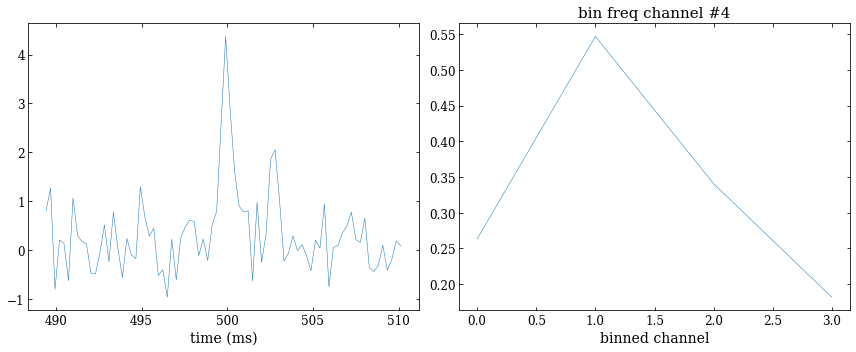

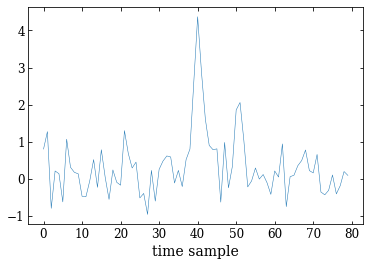

In [4]:
# read in de-dispersed data file
nfreq = 4

data = np.load('%s_%d.txt.npy'%(candidate, nfreq))

# chop near the burst region and plot 
data_burst = data[:, i_low: i_high] # change to x * width 
t_burst_ms = [i * bd.tsamp * 1e3 for i in range(i_low, i_high)]

fig1, ax1 = plt.subplots(1, 2, figsize=(12, 5)) 
#fig1.set_size_inches(12., 5.)
ax1[0].plot(t_burst_ms, data_burst.mean(0))
ax1[0].set_xlabel('time (ms)')
ax1[1].plot(data_burst.mean(1))
ax1[1].set_xlabel('binned channel')
ax1[1].set_title('bin freq channel #%d'%nfreq)
plt.tight_layout()

plt.figure()
plt.plot(data_burst.mean(0))
plt.xlabel('time sample')

## Fit with models

### bf_S1T2_cx: model-free spectrum + gaussian with scattering profile + x components

self.function_input_names:  ['S', 'mu', 'sigma', 'tau']
snames: ['c0', 'c1', 'c2', 'c3']
self.function_input_names:  ['c0', 'c1', 'c2', 'c3']


2022-05-16 23:00:12,177 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-16 23:00:12,178 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-16 23:00:12,183 - tests -root - INFO - P values: T-test (0.10514), Kruskal (0.04541), KS (0.04486), F-test (0.90495)
2022-05-16 23:00:12,185 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-05-16 23:00:12,187 - tests -root - INFO - P values: T-test (0.00158), Kruskal (0.00866), KS (0.02141), F-test (0.00515)
2022-05-16 23:00:12,189 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-05-16 23:00:12,191 - tests -root - INFO - P values: T-test (0.00002), Kruskal (0.00005), KS (0.00151), F-test (0.00008)
2022-05-16 23:00:12,193 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2022-05-16 23:00:12,195 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-05-16 23:00:12,220 - initial_profilefi

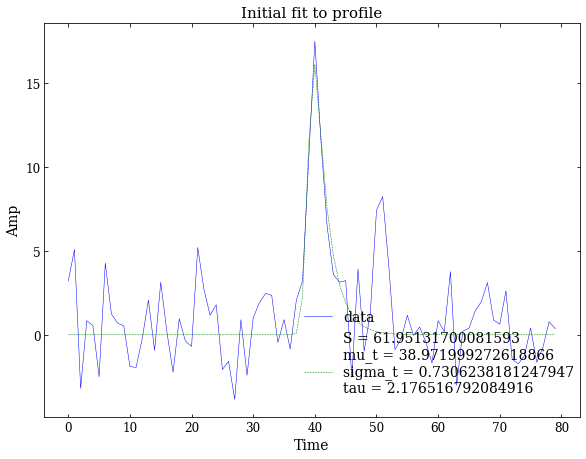

2022-05-16 23:00:12,368 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-16 23:00:12,371 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_4 at 0x7fd6349b1400>
[0.18606967 0.2985075  0.5038143  0.20928691]


2022-05-16 23:00:12,377 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-16 23:00:12,379 - initial_spectrafit -burstfit.fit - INFO - c0: 0.18606966733932495 +- 0.0
2022-05-16 23:00:12,382 - initial_spectrafit -burstfit.fit - INFO - c1: 0.2985075116157532 +- 0.0
2022-05-16 23:00:12,384 - initial_spectrafit -burstfit.fit - INFO - c2: 0.5038142800331116 +- 0.0
2022-05-16 23:00:12,387 - initial_spectrafit -burstfit.fit - INFO - c3: 0.2092869132757187 +- 0.0


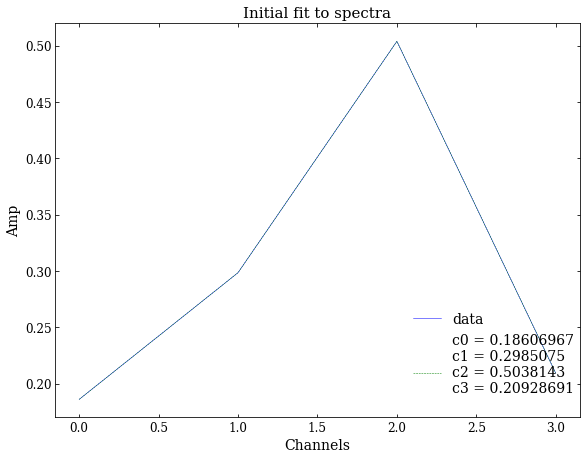

2022-05-16 23:00:12,560 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-16 23:00:12,562 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.18606967, 0.2985075, 0.5038143, 0.20928691, 61.95131700081593, 38.971999272618866, 0.7306238181247947, 2.176516792084916, 624.1]
2022-05-16 23:00:12,673 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-16 23:00:12,674 - sgram_fit -burstfit.fit - INFO - c0: 0.15806778964002002 +- 0.03856701629618944
2022-05-16 23:00:12,676 - sgram_fit -burstfit.fit - INFO - c1: 0.24230592673793513 +- 0.04153320221160055
2022-05-16 23:00:12,677 - sgram_fit -burstfit.fit - INFO - c2: 0.3974825366690249 +- 0.06100789015377985
2022-05-16 23:00:12,679 - sgram_fit -burstfit.fit - INFO - c3: 0.17288006831996552 +- 0.0509457150043289
2022-05-16 23:00:12,681 - sgram_fit -burstfit.fit - INFO - S: 68.46168756537983 +- 4.089284879766566
2022-05-16 23:00:12,682 - sgram_fit -burstfit.fit - INFO - mu_t: 3

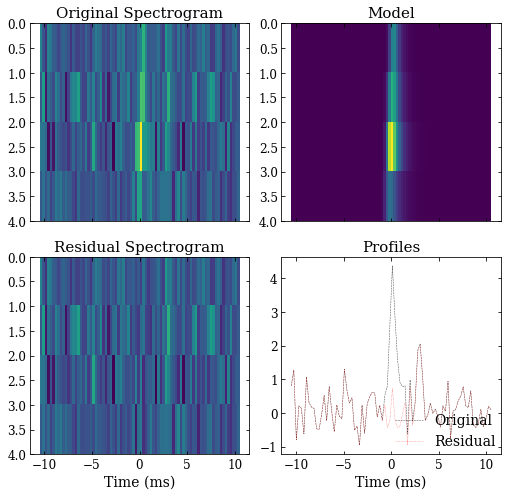

2022-05-16 23:00:13,036 - model -burstfit.fit - INFO - Making model.
2022-05-16 23:00:13,039 - model -burstfit.fit - INFO - Found 1 components.
2022-05-16 23:00:13,042 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-16 23:00:13,044 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-16 23:00:13,047 - model -burstfit.fit - INFO - Making model.
2022-05-16 23:00:13,048 - model -burstfit.fit - INFO - Found 1 components.
2022-05-16 23:00:13,052 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0217606424357153
2022-05-16 23:00:13,053 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-16 23:00:13,055 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-16 23:00:13,059 - tests -root - INFO - P values: T-test (0.10514), Kruskal (0.04541), KS (0.04486), F-test (0.90495)
2022-05-16 23:00:13,061 - run

bf_S1T2_c1.calc_redchisq()= 1.0217606424357153


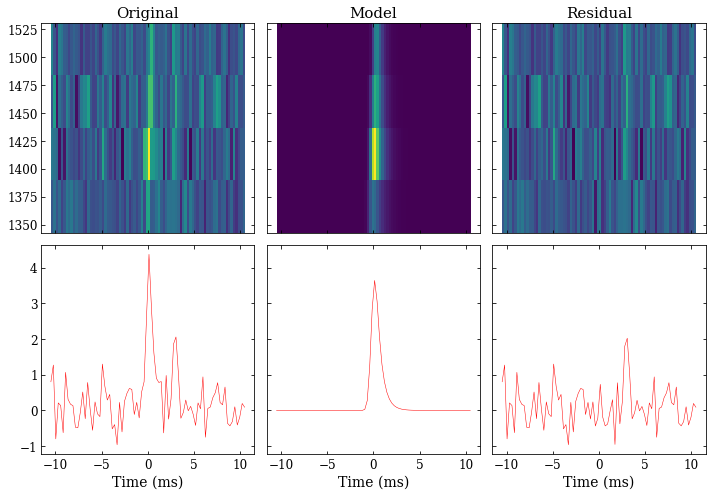

In [5]:
# bf_S1T2_c1: single component 
#data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)] # change to x * width 
#fit models  
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel

ncomp = 1 

pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)
#profile_bounds=[(0, 480, 0, 0),(np.inf, 510, 10*bd.width, np.inf)]


nfreq = 4
# For spectrum, try model-free  
nfreq_model = nfreq # try less 
snames = [0] * (nfreq_model)

for i in range(nfreq_model ):
    snames[i] = 'c'+str(i)

print('snames:', snames)
spectraModel = Model(model_free_4, param_names=snames)
#spectraModel = Model(model_free, param_names=snames)





sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])

#sgram_bounds=((0, 0.45, 0),(np.inf, 0.55, np.inf)) # did not work when only set up bounds but do not chop data 

# Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 
# initial fit: use heimdall results 
# rename bf_S1T2_c1 for later model selection 
bf_S1T2_c1 = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False,
    #comp_num = 1, 
)


# Some setting up before we do the fitting 
bf_S1T2_c1.validate()
bf_S1T2_c1.precalc()


# fit tests
#bf_S1T2_c1.initial_profilefit(plot = True) #bounds = profile_bounds, 
#bf_S1T2_c1.make_spectra
#bf_S1T2_c1.initial_spectrafit(plot = True)

#bf_S1T2_c1.fitcycle(plot=True) # fit for one component.
bf_S1T2_c1.fitall(plot=True, max_ncomp = ncomp) # fit all componnts 
print('bf_S1T2_c1.calc_redchisq()=', bf_S1T2_c1.calc_redchisq())

# plot fit for all components 
plot_fit_results(bf_S1T2_c1.sgram, bf_S1T2_c1.sgram_model.evaluate, bf_S1T2_c1.sgram_params['all'][1]['popt'], 
                 bf_S1T2_c1.tsamp, bf_S1T2_c1.fch1, bf_S1T2_c1.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
dm_fit, dm_fit_err = bf_S1T2_c1.sgram_params['all'][1]['popt'][-1], bf_S1T2_c1.sgram_params['all'][1]['perr'][-1]



In [37]:
bf_S1T2_c1.spectra

array([0.18606967, 0.2985075 , 0.5038143 , 0.20928691], dtype=float32)

In [8]:
#bf_S1T2_c1.off_pulse_ts_std

2022-04-27 22:37:22,785 - set_initial_pos -root - INFO - Setting initial positions for MCMC.
2022-04-27 22:37:22,788 - set_initial_pos -burstfit.mcmc - INFO - Initial guess for MCMC is: [1.57911130e-01 2.50706167e-01 4.14968939e-01 1.80096280e-01
 6.09073405e+01 1.19592663e+02 7.02782911e-01 1.39462999e+00
 6.23527515e+02]
2022-04-27 22:37:22,791 - set_priors -burstfit.mcmc - INFO - Setting priors for MCMC.
2022-04-27 22:37:22,794 - set_priors -burstfit.mcmc - INFO - Found tau in param_names. Setting its min value of prior to 0.
2022-04-27 22:37:22,797 - set_priors -burstfit.mcmc - INFO - Found sigma_t in param_names. Setting its min value of prior to 0.
2022-04-27 22:37:22,800 - set_priors -burstfit.mcmc - INFO - Found sigma_t and tau in param_names. Setting its max value of prior to 2*(max_tau_prior(2.510333974253267) + max_sigma_t_prior(1.2650092403919313))
2022-04-27 22:37:22,803 - set_priors -burstfit.mcmc - INFO - Found S and sigma_t in param_names. Setting its max value of prior

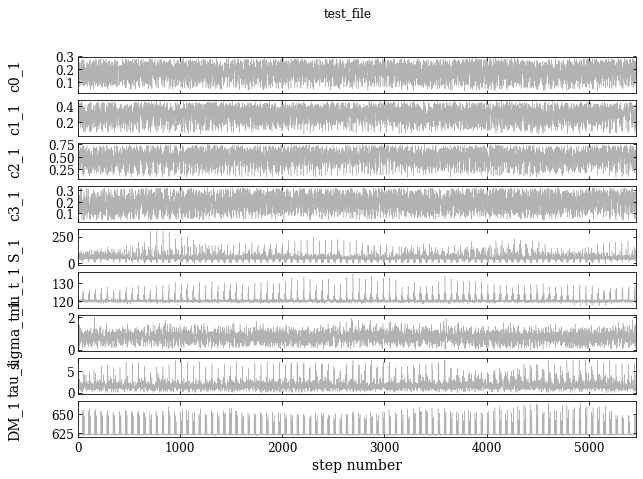

<Figure size 432x288 with 0 Axes>

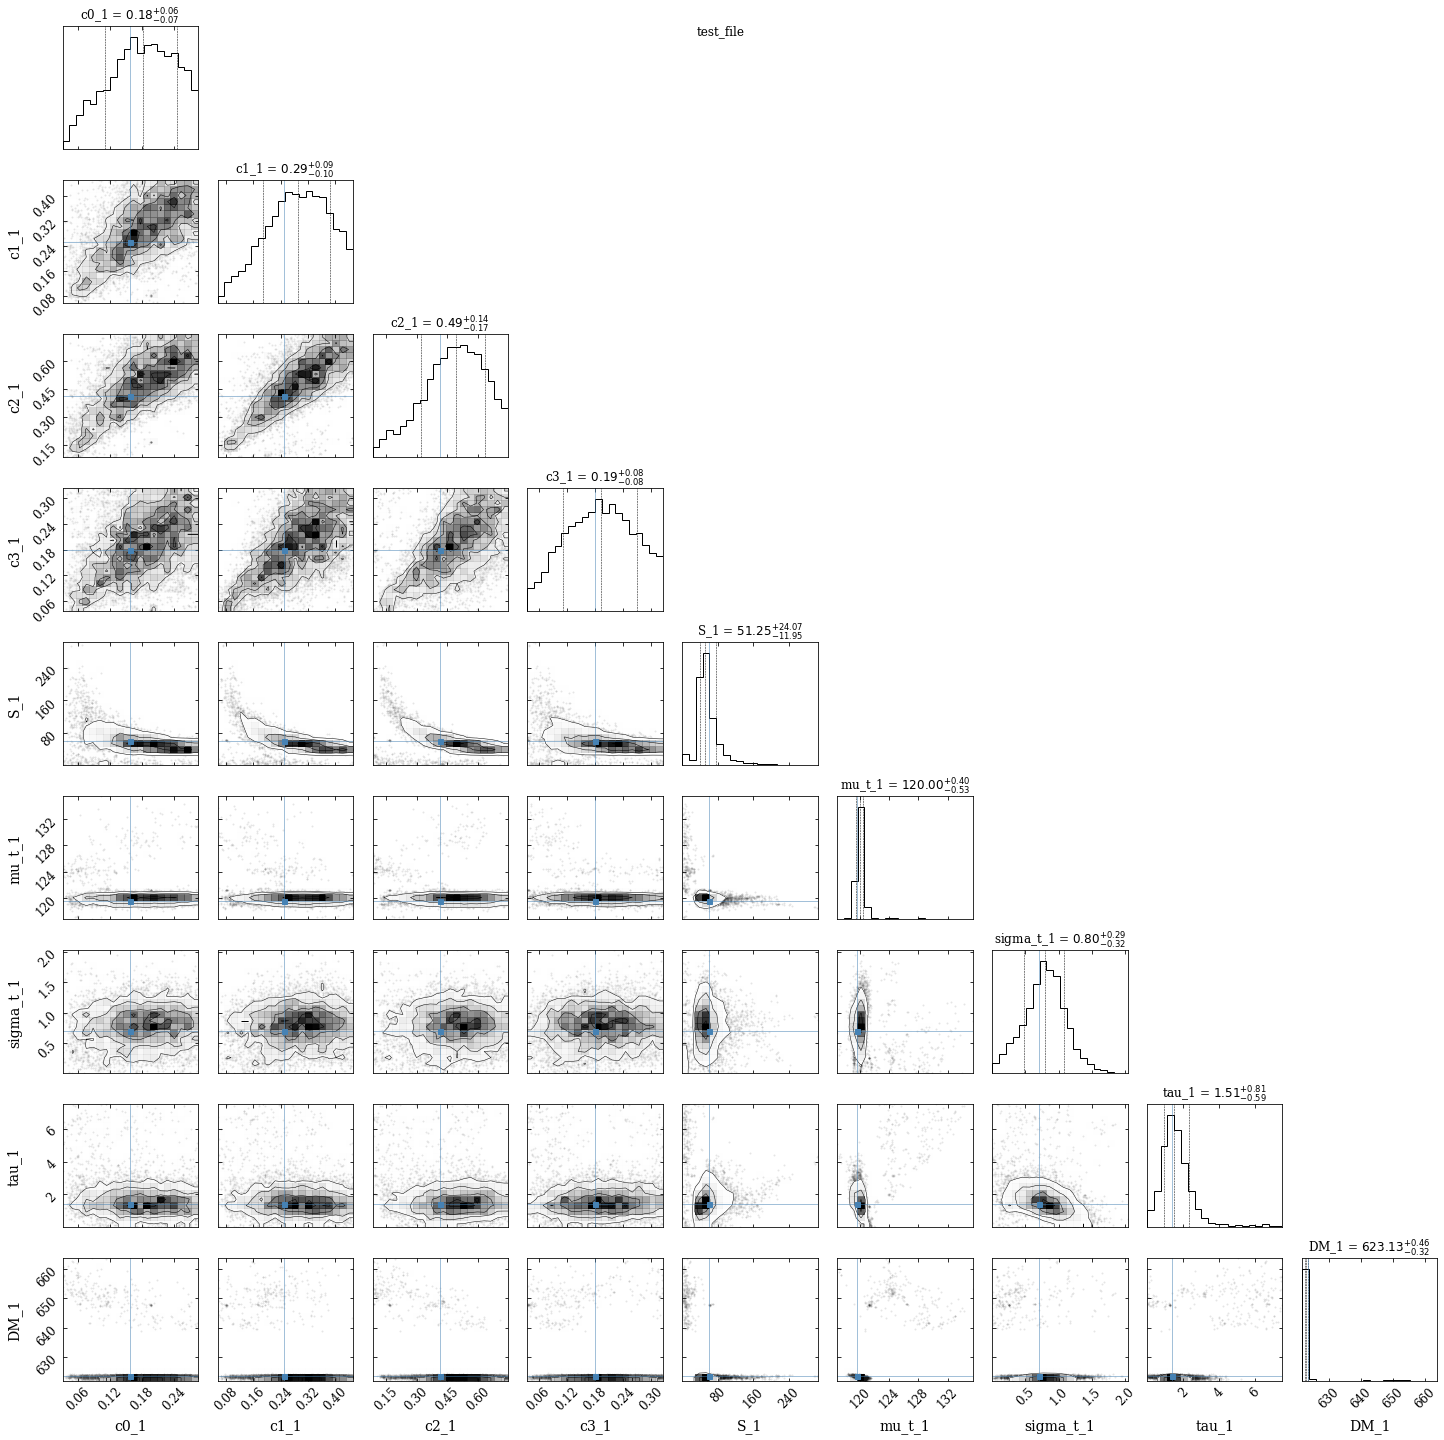

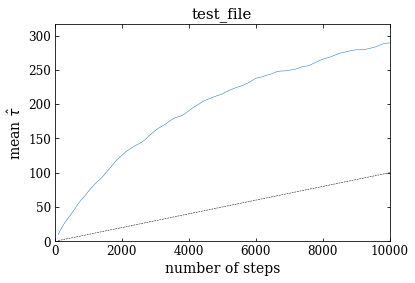

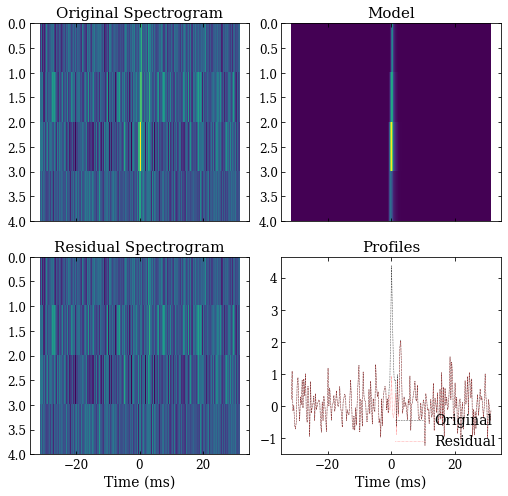

In [12]:
mcmc_kwargs = {}
mcmc_kwargs = {'nwalkers':60, 'nsteps':int(1e4),
           'skip':500, 'ncores':4, 
           'start_pos_dev':0.01,
           'prior_range':0.8, 
           'save_results':True,
           'outname':'test_file'}

bf_S1T2_c1.run_mcmc(plot=True, **mcmc_kwargs)


In [15]:
bf_S1T2_c1.mcmc_params

{1: {'popt': [0.1809698793798518,
   0.2916737185520088,
   0.491981805739685,
   0.19174278402963651,
   51.24874821630479,
   120.00340817016874,
   0.7964183320861222,
   1.5121829801942308,
   623.1346048544892],
  'perr': [[0.07046351880052457, 0.06345737012930583],
   [0.1026342788492986, 0.0931470140594563],
   [0.16828834608312704, 0.143290857634512],
   [0.07900457849189012, 0.07793023853069364],
   [11.952383292130705, 24.065788939754697],
   [0.5322533774773319, 0.3974524082510129],
   [0.32092021118908265, 0.28812809928407845],
   [0.5947210331834915, 0.810235803331242],
   [0.31685071863194025, 0.46096375187107697]]}}

self.function_input_names:  ['S', 'mu', 'sigma', 'tau']
snames: ['c0', 'c1', 'c2', 'c3']
self.function_input_names:  ['c0', 'c1', 'c2', 'c3']


2022-05-16 23:00:31,918 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-16 23:00:31,920 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-16 23:00:31,925 - tests -root - INFO - P values: T-test (0.10514), Kruskal (0.04541), KS (0.04486), F-test (0.90495)
2022-05-16 23:00:31,926 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-05-16 23:00:31,930 - tests -root - INFO - P values: T-test (0.00158), Kruskal (0.00866), KS (0.02141), F-test (0.00515)
2022-05-16 23:00:31,932 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-05-16 23:00:31,936 - tests -root - INFO - P values: T-test (0.00002), Kruskal (0.00005), KS (0.00151), F-test (0.00008)
2022-05-16 23:00:31,938 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2022-05-16 23:00:31,939 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-05-16 23:00:31,964 - initial_profilefi

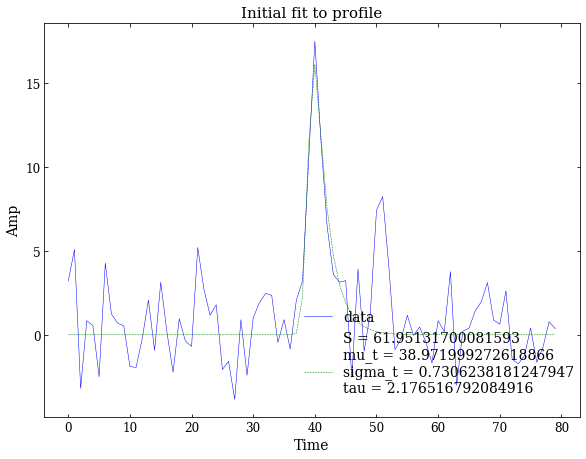

2022-05-16 23:00:32,118 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-16 23:00:32,120 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_4 at 0x7fd6349b1400>
[0.18606967 0.2985075  0.5038143  0.20928691]


2022-05-16 23:00:32,123 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-16 23:00:32,125 - initial_spectrafit -burstfit.fit - INFO - c0: 0.18606966733932495 +- 0.0
2022-05-16 23:00:32,126 - initial_spectrafit -burstfit.fit - INFO - c1: 0.2985075116157532 +- 0.0
2022-05-16 23:00:32,128 - initial_spectrafit -burstfit.fit - INFO - c2: 0.5038142800331116 +- 0.0
2022-05-16 23:00:32,130 - initial_spectrafit -burstfit.fit - INFO - c3: 0.2092869132757187 +- 0.0


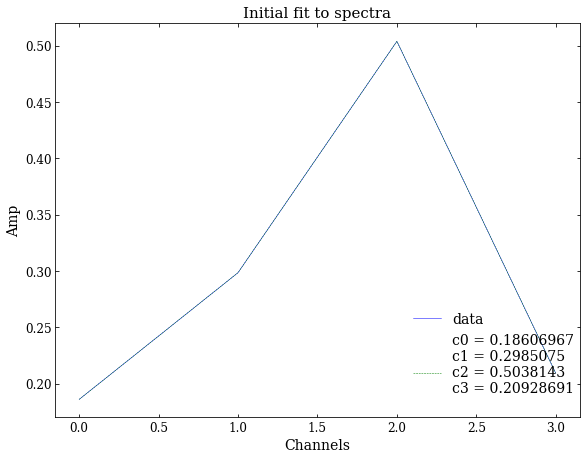

2022-05-16 23:00:32,277 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-16 23:00:32,280 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.18606967, 0.2985075, 0.5038143, 0.20928691, 61.95131700081593, 38.971999272618866, 0.7306238181247947, 2.176516792084916, 624.1]
2022-05-16 23:00:32,363 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-16 23:00:32,365 - sgram_fit -burstfit.fit - INFO - c0: 0.15806778964002002 +- 0.03856701629618944
2022-05-16 23:00:32,367 - sgram_fit -burstfit.fit - INFO - c1: 0.24230592673793513 +- 0.04153320221160055
2022-05-16 23:00:32,368 - sgram_fit -burstfit.fit - INFO - c2: 0.3974825366690249 +- 0.06100789015377985
2022-05-16 23:00:32,370 - sgram_fit -burstfit.fit - INFO - c3: 0.17288006831996552 +- 0.0509457150043289
2022-05-16 23:00:32,371 - sgram_fit -burstfit.fit - INFO - S: 68.46168756537983 +- 4.089284879766566
2022-05-16 23:00:32,372 - sgram_fit -burstfit.fit - INFO - mu_t: 3

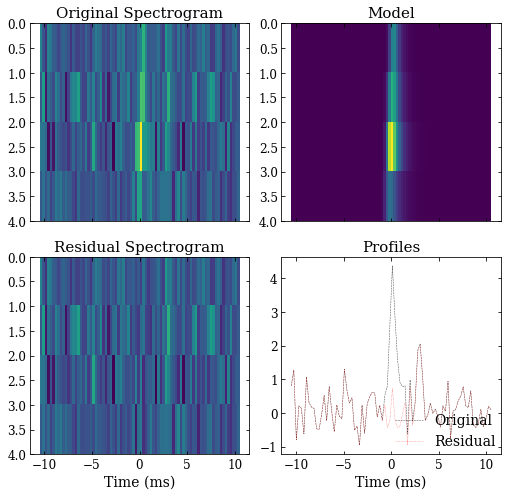

2022-05-16 23:00:32,793 - model -burstfit.fit - INFO - Making model.
2022-05-16 23:00:32,796 - model -burstfit.fit - INFO - Found 1 components.
2022-05-16 23:00:32,799 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-16 23:00:32,802 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-16 23:00:32,804 - model -burstfit.fit - INFO - Making model.
2022-05-16 23:00:32,806 - model -burstfit.fit - INFO - Found 1 components.
2022-05-16 23:00:32,810 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0217606424357153
2022-05-16 23:00:32,812 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-16 23:00:32,814 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-16 23:00:32,817 - tests -root - INFO - P values: T-test (0.10514), Kruskal (0.04541), KS (0.04486), F-test (0.90495)
2022-05-16 23:00:32,819 - run

{1: {'popt': [0.15806778964002002,
   0.24230592673793513,
   0.3974825366690249,
   0.17288006831996552,
   68.46168756537983,
   39.65486835112079,
   0.9139617032789397,
   1.6750274899254796,
   623.2860475222731],
  'perr': array([0.03856702, 0.0415332 , 0.06100789, 0.05094572, 4.08928488,
         0.35762186, 0.1096764 , 0.26197805, 0.3369181 ])},
 'all': {1: {'popt': [0.15806778964002002,
    0.24230592673793513,
    0.3974825366690249,
    0.17288006831996552,
    68.46168756537983,
    39.65486835112079,
    0.9139617032789397,
    1.6750274899254796,
    623.2860475222731],
   'perr': array([0.03856702, 0.0415332 , 0.06100789, 0.05094572, 4.08928488,
          0.35762186, 0.1096764 , 0.26197805, 0.3369181 ])}}}

In [6]:
# bf_S1T2_c2: two components
#data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)] # change to x * width 
#fit models  
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel
ncomp = 2 

pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)
profile_bounds=[(0, 480, 0, 0),(np.inf, 510, 10*bd.width, np.inf)]


nfreq = 4
# For spectrum, try model-free  
nfreq_model = nfreq # try less 
snames = [0] * nfreq_model

for i in range(nfreq_model):
    snames[i] = 'c'+str(i)

print('snames:', snames)
spectraModel = Model(model_free_4, param_names=snames)
#spectraModel = Model(model_free, param_names=snames)





sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])

#sgram_bounds=((0, 0.45, 0, -np.inf),(np.inf, 0.55, np.inf, np.inf)) # did not work when only set up bounds but do not chop data 

# Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 
# initial fit: use heimdall results 
# rename bf_S1T2_c2 for later model selection 
bf_S1T2_c2 = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False,
    #comp_num = 1, 
)


# Some setting up before we do the fitting 
bf_S1T2_c2.validate()
bf_S1T2_c2.precalc()


# fit tests
#bf_S1T2_c2.initial_profilefit(bounds = profile_bounds, plot = True)
#bf_S1T2_c2.initial_spectrafit(plot = True)

#bf_S1T2_c2.fitcycle(plot=True) # fit for one component.
bf_S1T2_c2.fitall(plot=True, max_ncomp = ncomp) # fit all componnts 
bf_S1T2_c2.calc_redchisq()

# plot fit for all components 
# plot_fit_results(bf_S1T2_c2.sgram, bf_S1T2_c2.sgram_model.evaluate, bf_S1T2_c2.sgram_params['all'][1]['popt'], 
#                  bf_S1T2_c2.tsamp, bf_S1T2_c2.fch1, bf_S1T2_c2.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
#dm_fit, dm_fit_err = bf_S1T2_c2.sgram_params['all'][1]['popt'][-1], bf_S1T2_c2.sgram_params['all'][1]['perr'][-1]

bf_S1T2_c2.sgram_params

In [23]:
bd.filterbank_header

<bound method SigprocFile.filterbank_header of Using <class 'str'>:
/data/dsa110/T1/corr02/2022_4_18_4_58_12/fil_220418aaai/220418aaai_66.fil>

### bf_S1T1_cx: model-free spectrum + gaussian profile NO scattering + x-component 

self.function_input_names:  ['S', 'mu', 'sigma']
snames: ['c0', 'c1', 'c2', 'c3']
self.function_input_names:  ['c0', 'c1', 'c2', 'c3']


2022-05-16 23:08:33,830 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-05-16 23:08:33,858 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2022-05-16 23:08:33,860 - initial_profilefit -burstfit.fit - INFO - S: 54.27214228933736 +- 6.503965685181566
2022-05-16 23:08:33,862 - initial_profilefit -burstfit.fit - INFO - mu_t: 40.19125461801029 +- 0.189994055010679
2022-05-16 23:08:33,865 - initial_profilefit -burstfit.fit - INFO - sigma_t: 1.372995408636111 +- 0.1899936834765888


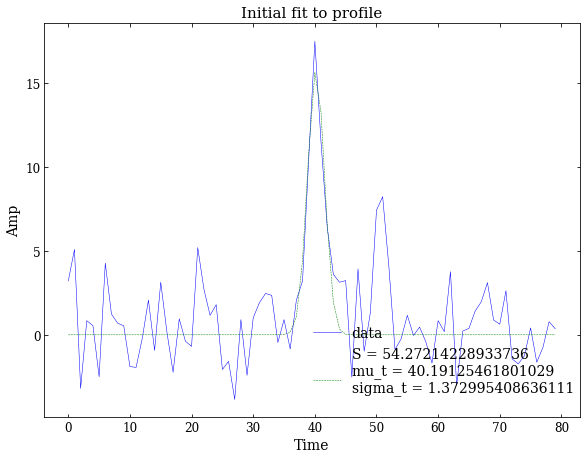

2022-05-16 23:08:34,060 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2022-05-16 23:08:34,063 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-05-16 23:08:34,089 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2022-05-16 23:08:34,091 - initial_profilefit -burstfit.fit - INFO - S: 54.27214228933736 +- 6.503965685181566
2022-05-16 23:08:34,094 - initial_profilefit -burstfit.fit - INFO - mu_t: 40.19125461801029 +- 0.189994055010679
2022-05-16 23:08:34,096 - initial_profilefit -burstfit.fit - INFO - sigma_t: 1.372995408636111 +- 0.1899936834765888


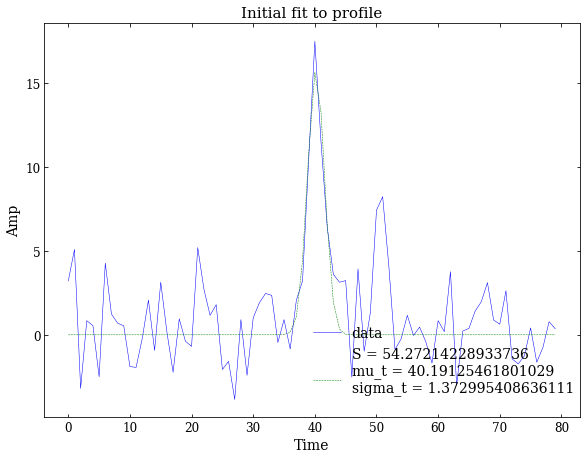

2022-05-16 23:08:34,273 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-16 23:08:34,276 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_4 at 0x7fd6349b1400>
[0.21605174 0.3286421  0.4598707  0.20692278]


2022-05-16 23:08:34,283 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-16 23:08:34,285 - initial_spectrafit -burstfit.fit - INFO - c0: 0.21605174243450165 +- 0.0
2022-05-16 23:08:34,287 - initial_spectrafit -burstfit.fit - INFO - c1: 0.3286421000957489 +- 0.0
2022-05-16 23:08:34,288 - initial_spectrafit -burstfit.fit - INFO - c2: 0.45987069606781006 +- 0.0
2022-05-16 23:08:34,290 - initial_spectrafit -burstfit.fit - INFO - c3: 0.20692278444766998 +- 0.0


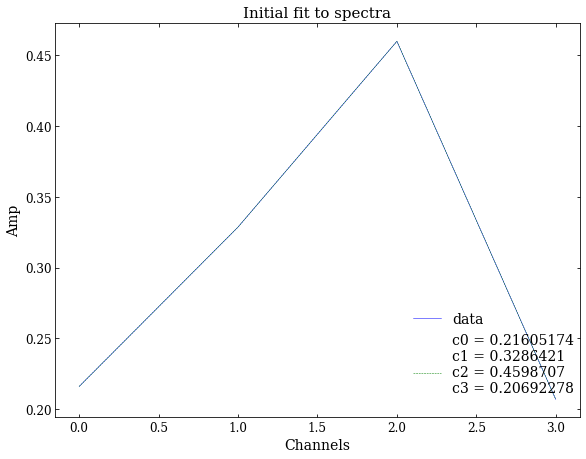

2022-05-16 23:08:34,467 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-16 23:08:34,469 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.21605174, 0.3286421, 0.4598707, 0.20692278, 54.27214228933736, 40.19125461801029, 1.372995408636111, 624.1]
2022-05-16 23:08:34,509 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-16 23:08:34,511 - sgram_fit -burstfit.fit - INFO - c0: 0.1718620069444376 +- 0.04404615716776545
2022-05-16 23:08:34,514 - sgram_fit -burstfit.fit - INFO - c1: 0.2537381968309475 +- 0.04752733407409178
2022-05-16 23:08:34,516 - sgram_fit -burstfit.fit - INFO - c2: 0.38929161686021113 +- 0.05546303488622654
2022-05-16 23:08:34,518 - sgram_fit -burstfit.fit - INFO - c3: 0.15034784471163337 +- 0.04472162627023098
2022-05-16 23:08:34,519 - sgram_fit -burstfit.fit - INFO - S: 58.73244007333189 +- 3.6272289248934038
2022-05-16 23:08:34,521 - sgram_fit -burstfit.fit - INFO - mu_t: 40.93595579463852 +- 

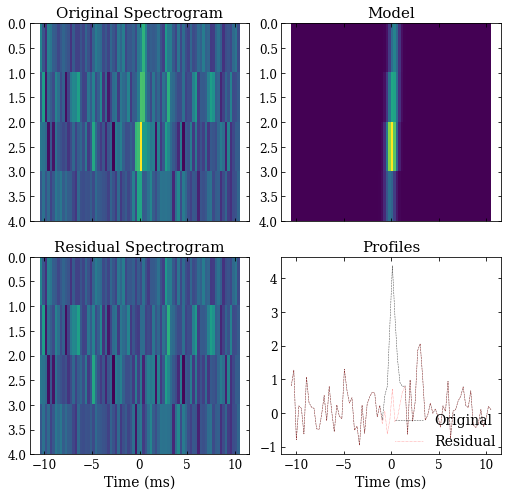

2022-05-16 23:08:34,947 - model -burstfit.fit - INFO - Making model.
2022-05-16 23:08:34,950 - model -burstfit.fit - INFO - Found 1 components.
2022-05-16 23:08:34,955 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-16 23:08:34,958 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-16 23:08:34,960 - model -burstfit.fit - INFO - Making model.
2022-05-16 23:08:34,962 - model -burstfit.fit - INFO - Found 1 components.
2022-05-16 23:08:34,966 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0299166116569938
2022-05-16 23:08:34,968 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-16 23:08:34,970 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-16 23:08:34,974 - tests -root - INFO - P values: T-test (0.10514), Kruskal (0.04541), KS (0.04486), F-test (0.90495)
2022-05-16 23:08:34,976 - run

bf_S1T1_c1.calc_redchisq()= 1.0299166116569938


In [18]:
# bf_S1T1_c1: single component 
#data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)] # change to x * width 
#fit models  
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel

ncomp = 1 

pnames = ['S', 'mu_t', 'sigma_t'] # , 'tau'
pulseModel = Model(gauss, param_names=pnames)
profile_bounds=[(0, 0.48 / bd.tsamp - i_low, 0),(np.inf, 0.51/ bd.tsamp - i_low, 5*bd.width)]



nfreq = 4
# For spectrum, try model-free  
nfreq_model = nfreq # try less 
snames = [0] * nfreq_model

for i in range(nfreq_model):
    snames[i] = 'c'+str(i)

print('snames:', snames)
spectraModel = Model(model_free_4, param_names=snames)
#spectraModel = Model(model_free, param_names=snames)


sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])

sgram_bounds=((-np.inf, -np.inf, -np.inf, -np.inf, 0, 0, 0),(np.inf, np.inf, np.inf, np.inf, np.inf, np.shape(data_burst)[1], np.inf)) # did not work when only set up bounds but do not chop data 

# Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 
# initial fit: use heimdall results 
# rename bf_S1T1_c1 for later model selection 
bf_S1T1_c1 = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False,
    #comp_num = 1, 
)


# Some setting up before we do the fitting 
bf_S1T1_c1.validate()
bf_S1T1_c1.precalc()


# fit tests
bf_S1T1_c1.initial_profilefit(bounds = profile_bounds, plot = True)
#bf_S1T1_c1.initial_spectrafit(plot = True)

bf_S1T1_c1.fitcycle(plot=True, profile_bounds = profile_bounds) # fit for one component.
bf_S1T1_c1.fitall(plot=True, max_ncomp = ncomp) # fit all componnts 
print('bf_S1T1_c1.calc_redchisq()=', bf_S1T1_c1.calc_redchisq())

# plot fit for all components 
# plot_fit_results(bf_S1T1_c1.sgram, bf_S1T1_c1.sgram_model.evaluate, bf_S1T1_c1.sgram_params['all'][1]['popt'], 
#                  bf_S1T1_c1.tsamp, bf_S1T1_c1.fch1, bf_S1T1_c1.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
#dm_fit, dm_fit_err = bf_S1T1_c1.sgram_params['all'][1]['popt'][-1], bf_S1T1_c1.sgram_params['all'][1]['perr'][-1]

#bf_S1T1_c1.sgram_params

In [ ]:
# save fitting results 
bd.prepare_data()
bio = BurstIO(bf, bd)
d = bio.save_results(outname=save_name+"_fit_results.json", outdir=save_dir)  
print(d['param_names'])

In [19]:
# # saving key burst paramters 
# mu_f_mcmc, sigma_f_mcmc, s_mcmc, mu_t_mcmc, sigma_t_mcmc, tau_mcmc, dm_mcmc = bf.mcmc_params[1]['popt']
# mu_f_mcmc_err, sigma_f_mcmc_err, s_mcmc_err, mu_t_mcmc_err, sigma_t_mcmc_err, tau_mcmc_err, dm_mcmc_err = bf.mcmc_params[1]['perr']

# t0 = 0.45 + mu_t_mcmc * bd.tsamp
# t0_err = [i * bd.tsamp for i in mu_t_mcmc_err] 

# width_ms = sigma_t_mcmc * bd.tsamp * 1e3 # in ms
# width_ms_err = [i * bd.tsamp for i in sigma_t_mcmc_err] 

# # with open(save_dir+save_name+"_fit_key_results.txt") as f:
# #     print('mu_f_mcmc, sigma_f_mcmc, s_mcmc, mu_t_mcmc, sigma_t_mcmc, tau_mcmc, dm_mcmc')
# #     print(bf.mcmc_params[1]['popt'])
# #     print('lower, upper bounds')
# #     print(bf.mcmc_params[1]['perr'])

# #outname=save_name+"_fit_results.json", outdir=save_dir